# Skin Disease Detection Using VAE

Goal: create an image classifier using VAE extracted features for malignant (spread) vs benign (don't spread) skin disease

## Package Installation

In [1]:
!pip install torchsummary

Install packages

In [2]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns

# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['font.size'] = 14

from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

from collections import Counter

import os


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Folder Setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


⚠️**MODIFY THIS LINE TO MATCH YOUR FOLDER STRUCTURE**⚠️

TODO: Uncomment and modify this line to navigate to the correct folder:

Navigate to the 'datasets' folder or the location where you have the 'ddidiversedermatologyimages' folder stored

In [1]:
# cd /path/to/dataset/folder

In [6]:
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

# Get the current directory
current_directory = os.getcwd()

# List all files in the current directory
files_in_directory = os.listdir(current_directory)

print("Files in the current directory:")
for file in files_in_directory:
    print(file)

Files in the current directory:
ddidiversedermatologyimages
vgg19-skin-4.pth
vgg19-skin-4.pt
vgg16-skin-4.pt
vgg16-skin-4.pth
resnet50-skin-4.pt
resnet50-skin-4.pth


In [7]:
# Current working directory
folder_name = 'ddidiversedermatologyimages'

# Metadata CSV file
metadata_path = 'ddidiversedermatologyimages/ddi_metadata.csv'

# Construct the relative path by joining the folder name with the current directory
folder_path = os.path.join(os.getcwd(), folder_name)

# OPTIONAL: Print all files and directories in the specified folder
contents = os.listdir(folder_path)
#print(contents)

In [8]:
# Create dataframe from metadata
df = pd.read_csv(metadata_path).drop("Unnamed: 0",axis="columns") # from csv of metadata

## Data Exploration

In [9]:
df.head(3)

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,56,True,melanoma-in-situ
1,2,000002.png,56,True,melanoma-in-situ
2,3,000003.png,56,True,mycosis-fungoides


In [10]:
# Print metadata column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DDI_ID     656 non-null    int64 
 1   DDI_file   656 non-null    object
 2   skin_tone  656 non-null    int64 
 3   malignant  656 non-null    bool  
 4   disease    656 non-null    object
dtypes: bool(1), int64(2), object(2)
memory usage: 21.3+ KB


In [11]:
# Count fo skin tones
count_skin_tones = df.skin_tone.value_counts()
count_skin_tones

34    241
12    208
56    207
Name: skin_tone, dtype: int64

To get a sense of what the skintone numbers mean, print an image from each of the skintone groups

In [12]:
def display_image_by_skin_tone(df, skin_tone, folder_path):
    # Get a dataframe of just the specified skin tone
    filtered_df = df[df['skin_tone'] == skin_tone].reset_index(drop=True)

    if len(filtered_df) == 0:
        print(f"No entries found for skin tone {skin_tone}.")
        return

    # Get the value in the 'DDI_file' column of the first row
    file_value = filtered_df.loc[0, 'DDI_file']

    # Convert the value to a string
    image_filename = str(file_value)

    # Check if the image file exists in the specified folder
    if os.path.exists(os.path.join(folder_path, image_filename)):
        print(f"skin tone: {skin_tone}")
        img = mpimg.imread(os.path.join(folder_path, image_filename))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"Image {image_filename} not found in the specified folder.")


skin tone: 56


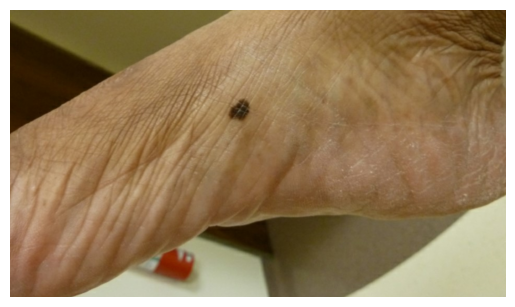

skin tone: 12


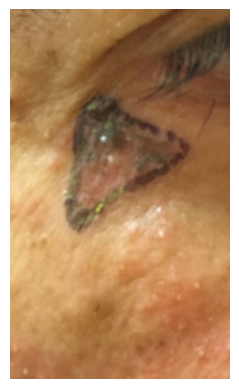

skin tone: 34


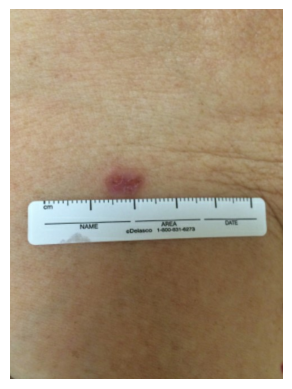

In [13]:
distinct_skin_tones = df['skin_tone'].unique().tolist()
for skin_tone in distinct_skin_tones:
  display_image_by_skin_tone(df, skin_tone, folder_path)

Not a lot of veriety here...

Replace skintones with abitrary letter to make sure training later does not attribute important characteristics to numerical differences

In [14]:
# Define the mapping of values to be replaced
alpha_mapping = {12: 'a', 34: 'b', 56: 'c'}

# Update the 'skin_tone' column using the mapping
df['skin_tone_alpha'] = df['skin_tone'].replace(alpha_mapping)

# Check the updated DataFrame
print(df.head())

   DDI_ID    DDI_file  skin_tone  malignant                          disease  \
0       1  000001.png         56       True                 melanoma-in-situ   
1       2  000002.png         56       True                 melanoma-in-situ   
2       3  000003.png         56       True                mycosis-fungoides   
3       4  000004.png         56       True  squamous-cell-carcinoma-in-situ   
4       5  000005.png         12       True             basal-cell-carcinoma   

  skin_tone_alpha  
0               c  
1               c  
2               c  
3               c  
4               a  


Text(0.5, 0, 'count skin tones')

Text(0, 0.5, 'skin tone')

Text(0.5, 1.0, 'Skin Tones in Data Set')

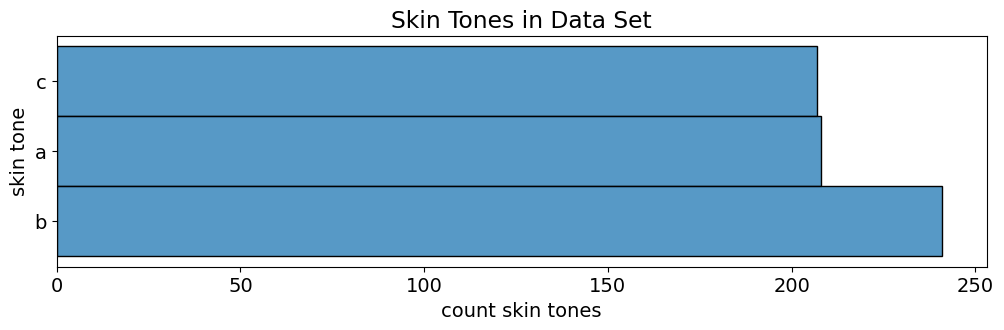

In [15]:
# Visualize Skin tone count
f, ax = plt.subplots(figsize=(12, 3))
ax = sns.histplot(data=df, y='skin_tone_alpha')
ax.set_xlabel('count skin tones')
ax.set_ylabel('skin tone')
ax.set_title('Skin Tones in Data Set')
plt.show()

Text(0.5, 1.0, 'Percentage of Malignant/Benign Skin Conditions')

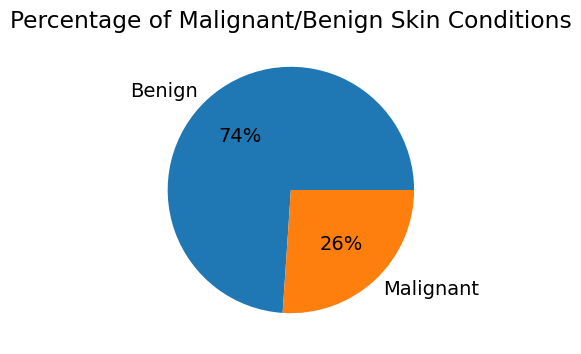

In [16]:
# Visualize malignant vs benign in dataset
f, ax = plt.subplots(figsize=(4, 4))
data = df.malignant.value_counts()
keys = ['Benign','Malignant']
ax = plt.pie(data, labels=keys, autopct='%.0f%%')
plt.title('Percentage of Malignant/Benign Skin Conditions')
plt.show()

Visualize benign vs malignant by skin tone

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Skin Tone', ylabel='Count'>

Text(0.5, 0, 'Skin Tone')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Number of Malignant vs Benign Entries by Skin Tone')

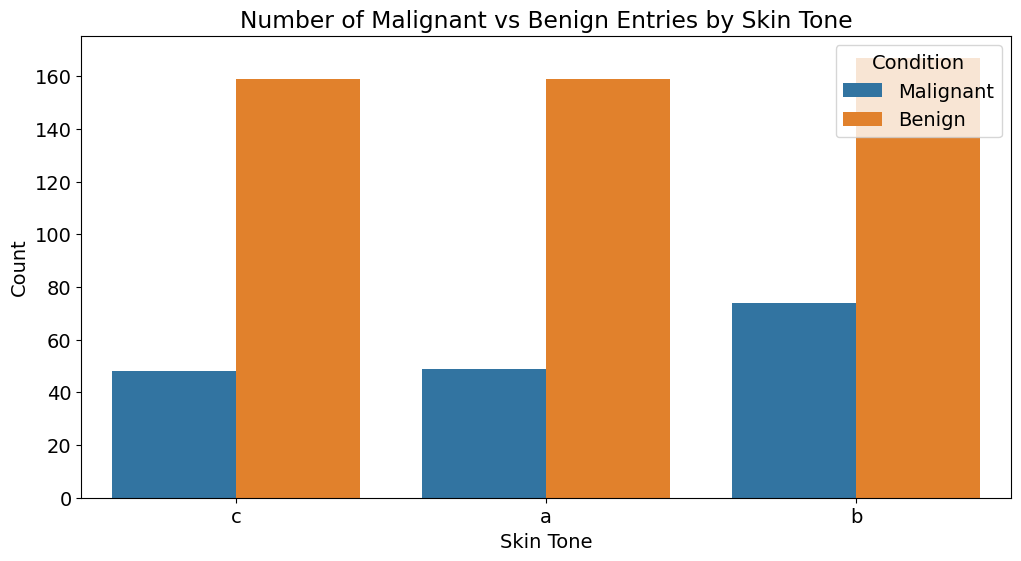

In [17]:
# Create a DataFrame for malignant and benign entries
malignant_df = df[df['malignant'] == True]
benign_df = df[df['malignant'] == False]

# Count the occurrences of each skin tone for malignant and benign entries
malignant_counts = malignant_df['skin_tone'].value_counts()
benign_counts = benign_df['skin_tone'].value_counts()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Skin Tone': df['skin_tone_alpha'].unique(),
    'Malignant': [malignant_counts.get(tone, 0) for tone in df['skin_tone'].unique()],
    'Benign': [benign_counts.get(tone, 0) for tone in df['skin_tone'].unique()]
})

# Melt the DataFrame for easy plotting
melted_df = pd.melt(plot_df, id_vars='Skin Tone', var_name='Condition', value_name='Count')

# Plot the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Skin Tone', y='Count', hue='Condition', data=melted_df)
plt.xlabel('Skin Tone')
plt.ylabel('Count')
plt.title('Number of Malignant vs Benign Entries by Skin Tone')
plt.show()

## Load Images

In [18]:
# Define the function to load and preprocess images
def load_and_preprocess_image(file_path):
    '''
    Load the image using PIL, convert to 3 channel images (some images has 4 channels),
    and convert to numpy array
    '''
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = np.array(image)
    return image

In [19]:
# Load and preprocess images for the entire dataset
image_data = []
labels = []
skin_tones = []
for index, row in df.iterrows():
    image_path = 'ddidiversedermatologyimages/' + row['DDI_file']
    label = row['malignant']
    skin_tone = row['skin_tone']
    image = load_and_preprocess_image(image_path)
    image_data.append(image)
    labels.append(label)
    skin_tones.append(skin_tone)

# Convert image_data and labels to NumPy arrays
image_data = np.array(image_data,dtype=object)
labels = np.array(labels,dtype=int)
skin_tones = np.array(skin_tones)

In [20]:
# Sanity check
print(type(labels))
print(labels[:50])

<class 'numpy.ndarray'>
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 0 0 0 1]


### Split into Train, Validation, and Test

In [21]:
# Split the data into training, validation, and testing sets
X_train, X_intermediate,st_train,st_intermediate, y_train, y_intermediate = train_test_split(image_data, skin_tones, labels, test_size=0.2, random_state=42)
X_val, X_test, st_val, st_test, y_val, y_test = train_test_split(X_intermediate, st_intermediate, y_intermediate, test_size=0.5, random_state=42)


In [22]:
# sanity check
print(f"Total values in dataset: {len(X_train) + len(X_val) + len(X_test)}")
print(f"Training set has {len(X_train)} values and {len(y_train)} labels")
print(f"Validation set has {len(X_val)} values and {len(y_val)} labels")
print(f"Test set has {len(X_test)} values and {len(y_test)} labels")

Total values in dataset: 656
Training set has 524 values and 524 labels
Validation set has 66 values and 66 labels
Test set has 66 values and 66 labels


In [23]:
X_train[0].shape
y_train[0]

(386, 391, 3)

0

### Augment Training Data
In this section, we generate more images with corresponding labesl and add to training images and labels.

In [24]:
df.head(3)

,DDI_ID,DDI_file,skin_tone,malignant,disease,skin_tone_alpha
0,1,000001.png,56,True,melanoma-in-situ,c
1,2,000002.png,56,True,melanoma-in-situ,c
2,3,000003.png,56,True,mycosis-fungoides,c


#### Create Generator

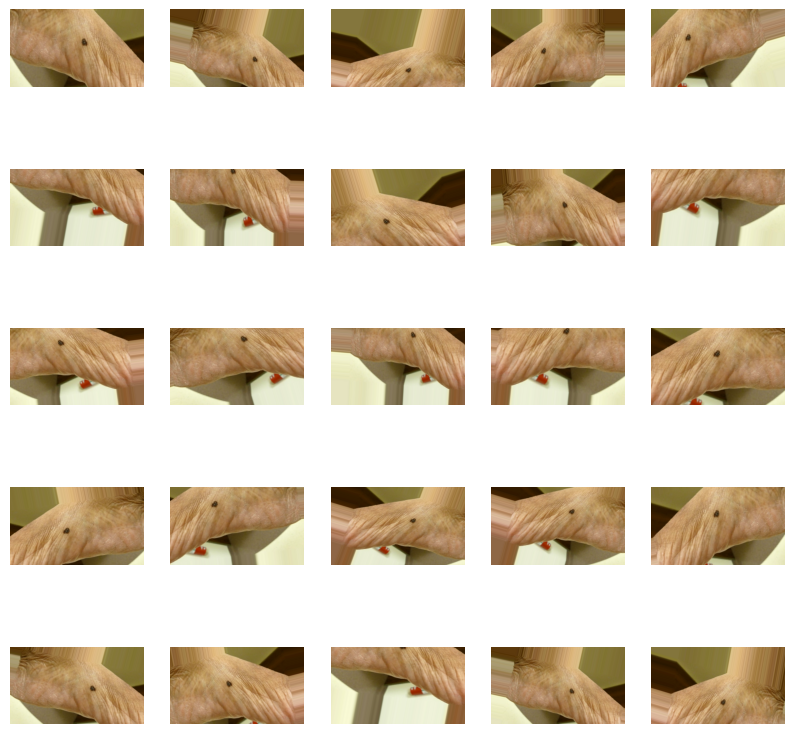

In [25]:
# Create an ImageDataGenerator with desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Load and preprocess a sample image
image_path = 'ddidiversedermatologyimages/000001.png'
x = load_and_preprocess_image(image_path)
x = x.reshape((1,) + x.shape)

# Initialize a counter
i = 0

# Create a figure for plotting
_ = plt.figure(figsize=(10, 10))

# Loop to generate and show transformed images
for batch in datagen.flow(x, batch_size=1):
    i += 1

    # Display the image
    _ = plt.subplot(5, 5, i)
    _ = plt.imshow(array_to_img(batch[0]))
    _ = plt.axis('off')

    if i >= 25:
        break

# Show the images
plt.show()

In [26]:
# THIS WILL CRASH IF YOU TRY TO DO IT WITH THE ENTIRE DATAFRAME
# Create an ImageDataGenerator with desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Function to apply transformations to an image and return a dataframe row
def generate_transformed_images(image, label, st, num_transformations=2): # not enough RAM for 25 tranformations
    '''
    image: ndarray
    label: int
    st: int
    '''
    x = image.reshape((1,) + image.shape)
    transformed_images = []
    labels = []
    skin_tones = []

    for batch in datagen.flow(x, batch_size=1):
        transformed_images.append((batch[0]).astype('uint8'))
        labels.append(label.astype('uint8'))
        skin_tones.append(st.astype('uint8'))
        if len(transformed_images) >= num_transformations:
            break
    return transformed_images, labels, skin_tones

In [27]:
# randomly generate 10 indexes from X_train to augment
idx_to_transform = np.random.choice(len(X_train), 100, replace=False)

transformed_X = []
transformed_y = []
transformed_st = []

# get img and label from X_train and y_train
for i in idx_to_transform:
  img = X_train[i]
  label = y_train[i]
  st = st_train[i]
  new_image, new_label, new_st = generate_transformed_images(img, label, st)
  transformed_X += new_image
  transformed_y += new_label
  transformed_st += new_st

# add transformed_X to original training images X_trian
transformed_X = np.array(transformed_X, dtype=object)
X_train_aug = np.concatenate((X_train, transformed_X), axis=0)

# add transformed_y to original training labels y_train
transformed_y = np.array(transformed_y, dtype=object)
y_train_aug = np.concatenate((y_train, transformed_y), axis=0)

# add transformed_st to original training skin_tones st_train
transformed_st = np.array(transformed_st, dtype=object)
st_train_aug = np.concatenate((st_train, transformed_st), axis=0)

In [28]:
print("Data size before Augmentation: ", len(X_train))
print("Data size after Augmentation: ", len(X_train_aug))

Data size before Augmentation:  524
Data size after Augmentation:  724


In [29]:
y_train_aug[:50]

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0], dtype=object)

### Load into Dataloader

In [30]:
# Define a custom dataset class by inheriting from torch.utils.data.Dataset
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

        # Create a mapping from unique class labels to indices
        self.class_to_idx = {class_label: idx for idx, class_label in enumerate(set(labels))}
        # new
        self.idx_to_class = {idx: int(class_label) for class_label, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        # If the sample is a file path, load it as a PIL Image
        if isinstance(sample, str):
          sample = Image.open(sample).convert('RGB')
        if self.transform:
            sample = self.transform(sample)
        return sample, label


In [31]:
# Define data transforms for image preprocessing
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.ToTensor(), # Convert images to PyTorch tensors
        # transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)), # 256
        transforms.Resize((128,128)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=224),  # Image net standards
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.ToTensor(), # Convert images to PyTorch tensors
        transforms.Resize((128,128)), # (256,256)
        # transforms.CenterCrop(size=224),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128,128)), # (256,256)
        # transforms.CenterCrop(size=224),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [32]:
# Set batch_size
batch_size=8

train_dataset = CustomDataset(X_train_aug, y_train_aug, transform=image_transforms['train'])
val_dataset = CustomDataset(X_val, y_val, transform=image_transforms['val'])
test_dataset = CustomDataset(X_test, y_test, transform=image_transforms['test'])

print(len(train_dataset))
print(len(val_dataset))
print(len(val_dataset))

724
66
66


In [33]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True),
    'test': DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
}

In [34]:
trainiter = iter(dataloaders['train'])
img, labels = next(trainiter) # issue with current augmentation set up: need to do totensor first
img.shape, labels.shape

(torch.Size([8, 3, 128, 128]), torch.Size([8]))

(0.0, 1.0, 0.0, 1.0)

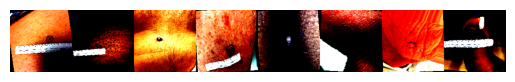

In [35]:
# Visualize one batch of images
row_of_images = torch.cat([img[i] for i in range(batch_size)], dim=2).permute(1,2,0)
plt.axis("off")
plt.imshow(row_of_images)
plt.show()

In [36]:
n_classes = len(torch.unique(labels))
n_classes

2

## Check Availability of GPU

In [37]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [38]:
print(train_on_gpu)

True


Now we will build models for the classification problem: VAE and pretrained models (vgg16, vgg19, resnet50)

## VAE

### Define and Train VAE Model

Source: https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.*py*

In [39]:
class VAE(torch.nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.hidden_dims = [32, 64, 128, 256, 512]
    self.latent_dim = latent_dim
    in_channels = 3

    # Build Encoder
    modules = []
    for h_dim in self.hidden_dims:
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels=h_dim,
                          kernel_size= 3, stride= 2, padding  = 1),
                nn.BatchNorm2d(h_dim),
                nn.LeakyReLU())
        )
        in_channels = h_dim
    self.encoder = nn.Sequential(*modules)
    self.fc_mu = nn.Linear(8192, self.latent_dim) # 32768 for 256x256 images
    self.fc_var = nn.Linear(8192, self.latent_dim)

    # Build Decoder
    modules = []
    self.decoder_input = nn.Linear(self.latent_dim, self.hidden_dims[-1] * 16) # *64 for 256x256 images
    self.hidden_dims.reverse()
    for i in range(len(self.hidden_dims) - 1):
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(self.hidden_dims[i],
                                    self.hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=1,
                                    output_padding=1),
                nn.BatchNorm2d(self.hidden_dims[i + 1]),
                nn.LeakyReLU())
        )
    self.decoder = nn.Sequential(*modules)
    # last layer of decoder
    self.final_layer = nn.Sequential(
                          nn.ConvTranspose2d(self.hidden_dims[-1],
                                              self.hidden_dims[-1],
                                              kernel_size=3,
                                              stride=2,
                                              padding=1,
                                              output_padding=1),
                          nn.BatchNorm2d(self.hidden_dims[-1]),
                          nn.LeakyReLU(),
                          nn.Conv2d(self.hidden_dims[-1], out_channels= 3,
                                    kernel_size= 3, padding= 1),
                          nn.Tanh())
    self.decoder = nn.Sequential(*modules)

  def forward(self, X):
    mu,sigma = self.encode(X)
    x = self.reparameter(mu,sigma) # sample from the distribution with mu and sigma
    x = self.decode(x) # reconstruct
    return x,mu,sigma

  def encode(self,x):
    x = self.encoder(x)
    x = torch.flatten(x, start_dim=1)
    mu = self.fc_mu(x)
    sigma = self.fc_var(x)
    return mu,sigma

  def decode(self,x):
    x = self.decoder_input(x)
    # x = x.view(-1, 512, 8, 8) # for 256x256 images
    x = x.view(-1, 512, 4, 4) # for (128x128 images)
    x = self.decoder(x)
    x = self.final_layer(x)
    return x

  def reparameter(self,mu,sigma):
    if torch.cuda.is_available():
      eps = torch.empty_like(sigma).normal_().cuda() # an uninitialized tensor with shape like sigma, filled with an N(0,1) sample
    else:
      eps = torch.empty_like(sigma).normal_()

    new_eps = torch.mul(eps,torch.exp(0.5*sigma)) + mu
    return new_eps

In [40]:
class VAE_loss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,pred_x,x,mu,sigma):
    log_loss = self.log_loss(pred_x,x)
    KLD_loss = self.KLD_loss(mu,sigma)
    loss = log_loss + KLD_loss
    return loss

  def log_loss(self,pred_x,x):
    mse = torch.nn.MSELoss(reduction='sum') # reconstruction loss
    log_loss = mse(pred_x,x)
    return log_loss

  def KLD_loss(self,mu,sigma):
    sigma2 = torch.exp(sigma)
    mu2 = torch.pow(mu,2)
    kld_loss = -0.5*torch.sum(1+sigma-mu2-sigma2)
    return kld_loss

In [41]:
def curve_plt(epoch,train_loss,val_loss,name = ''):
  plt.figure(1)
  plt.gca()
  plt.plot(epoch,train_loss,color='r', linewidth=1, alpha=0.6,label='train'+name+'_loss')
  plt.plot(epoch,val_loss,color='b', linewidth=1, alpha=0.6,label='val'+name+'_loss')
  plt.xlabel('epoch')
  plt.ylabel(name+'loss')
  plt.legend()
  plt.show()

Define train and test functions:

In [42]:
def train(vae, epoch):
  train_per_loss = 0
  vae.train()
  for i,(train_x,train_y) in enumerate(dataloaders['train']):
    # if len(train_x) < batch_size: # ignore leftover batches
    #   break
    inputs = torch.autograd.Variable(train_x).cuda()
    optimizer.zero_grad()
    output,mu,sigma = vae(inputs)
    loss = criterion(output,inputs,mu,sigma)
    loss.backward()
    optimizer.step()
    train_per_loss = train_per_loss + loss.item()
    if i%1000 == 999:
      print('%5d: Loss: %.3f,log_Loss: %.3f,klf_Loss: %.3f'%(i,loss.item()))
  return  train_per_loss

def test(vae): # on validation dataset
  val_per_loss = 0
  vae.eval()
  with torch.no_grad():
    for i,(val_x,val_y) in enumerate(dataloaders['val']):
      inputs = torch.autograd.Variable(val_x).cuda()
      output,mu,sigma = vae(inputs)
      loss = criterion(output,inputs,mu,sigma)
      val_per_loss = val_per_loss + loss.item()
      if i%1000 == 999:
        print('%5d: Loss: %.3f'%(i,loss.item()))
  return val_per_loss

We will construct 4 VAE networks with different latent dimensions: 32, 64, 128, and 256, and compare their performance in reconstructing input images.

27211741.25
13333543.0
11926664.27734375


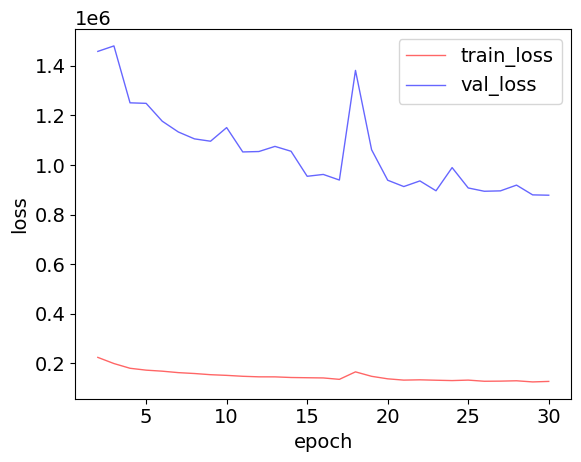

27071806.9375
12757567.890625
11371116.7265625


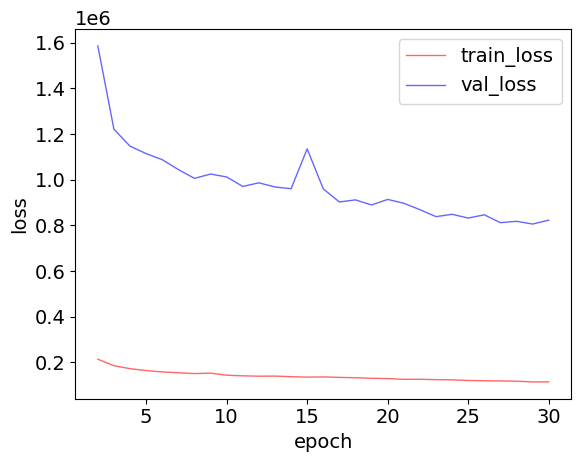

26354156.9375
13371725.35546875
11221224.67578125


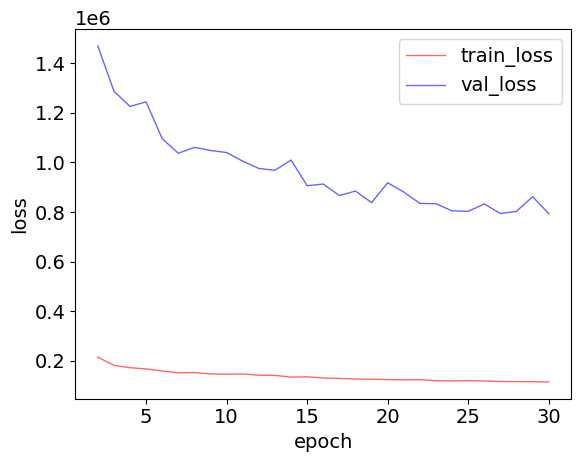

26366645.21875
13010456.9765625
11942709.671875


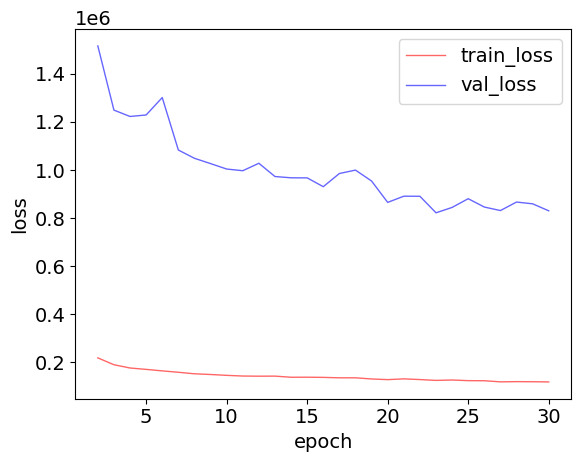

In [54]:
# Construct 4 vae networks with different latent dimensions
vae_32 = VAE(32)
vae_64 = VAE(64)
vae_128 = VAE(128)
vae_256 = VAE(256)

for vae_network in [vae_32, vae_64, vae_128, vae_256]:
  if torch.cuda.is_available():
    vae_network = vae_network.cuda()
  criterion = VAE_loss()
  optimizer = torch.optim.Adam(vae_network.parameters(),lr = 0.001,weight_decay=1e-5)
  num_epochs = 30

  # init list
  train_loss = []
  val_loss = []
  epoch_set = []
  for epoch in range(num_epochs):
    epoch_set.append(epoch+1)
    # train
    train_per_loss = train(vae_network, epoch)
    train_loss.append(train_per_loss/len(dataloaders['train']))
    if not epoch % 10:
      print(train_per_loss)
    val_per_loss = test(vae_network)
    val_loss.append(val_per_loss/len(dataloaders['val']))

  k = 1
  curve_plt(epoch_set[k:],train_loss[k:],val_loss[k:],name = '')


### Visualize VAE Results

Next we visualize some reconstructed images with different latent dimensions.

In [55]:
def reconstruct(vae_ls, data_loader, num_img):
  """
  vae_ls: a list of trained vae network
  data_loader: Dataloader obj
  num_img: int
  """
  with torch.no_grad():
      for i,(x,y) in enumerate(data_loader):
        if i >= num_img:
          break
        output_imgs = [x[0].permute(1,2,0)] # first = input, rest = recostruction from different vae
        for vae in vae_ls:
          vae.eval()
          input = torch.autograd.Variable(x).cuda()
          output,mu,sigma = vae(input)
          output = output[0].permute(1,2,0).cpu().detach()
          output_imgs.append(output)

        row_display = np.concatenate(output_imgs, axis=1)
        plt.imshow(row_display)
        plt.axis('off')
        plt.show()


In [56]:
# We define a new train & test loader with batch size = 1
train_loader_2 = DataLoader(train_dataset, batch_size=1, shuffle=False) # set batchsize=1 for visualization purpose
test_loader = DataLoader(test_dataset,batch_size=1, shuffle=False)

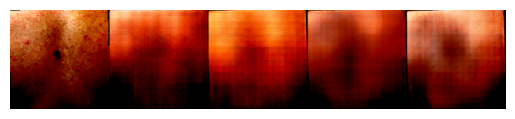

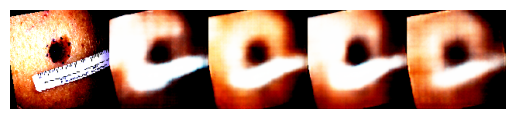

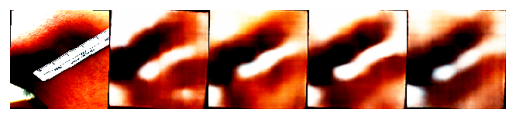

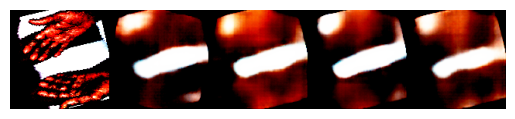

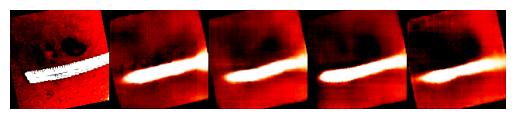

In [57]:
# Reconstruct training images
vae_ls = [vae_32, vae_64, vae_128, vae_256]
reconstruct(vae_ls, train_loader_2, 5)

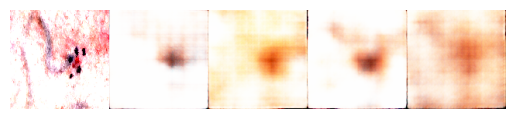

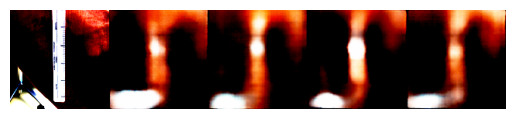

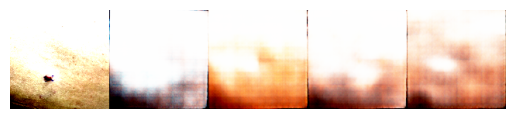

In [58]:
# Reconstruct testing images
reconstruct(vae_ls, test_loader, 3)

We can also generate new images by sampling from latent space.


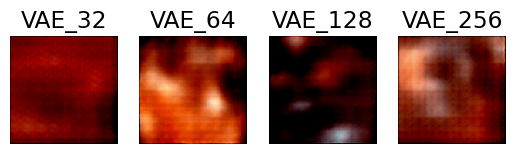

In [59]:
def sample(vae, latent_dim, num_samples=1):
      z = torch.randn(num_samples, latent_dim)
      z = z.to('cuda')
      output = vae.decode(z)
      output = output[0].permute(1,2,0).cpu().detach()
      return output

fig, ax = plt.subplots(1,4)
img_32 = sample(vae_32, 32, 1)
_ = ax[0].imshow(img_32)
_ = ax[0].axis('off')
_ = ax[0].set_title("VAE_32")

img_64 = sample(vae_64, 64, 1)
_ = ax[1].imshow(img_64)
_ = ax[1].axis('off')
_ = ax[1].set_title("VAE_64")

img_128 = sample(vae_128, 128, 1)
_ = ax[2].imshow(img_128)
_ = ax[2].axis('off')
_ = ax[2].set_title("VAE_128")

img_256 = sample(vae_256, 256, 1)
_ = ax[3].imshow(img_256)
_ = ax[3].axis('off')
_ = ax[3].set_title("VAE_256")

# plt.title("Generated Images from VAEs of different latent dimensions")
plt.show()

### Extract features (get latent representation)

Next we will use the latent representations learned in **VAE_32** to complete our the classification task.

25337059.0703125
13325937.96875
11508961.953125
10757242.31640625
10317515.83984375
10202814.1015625
9868491.71484375
9795210.921875
9635313.91796875
9589265.703125
9368626.8125
9247609.19921875


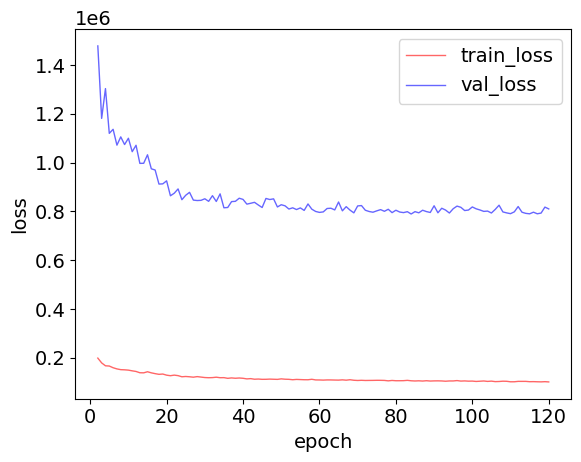

In [83]:
# We can train another vae32 for more epochs
vae_32 = VAE(32)

for vae_network in [vae_32]:
  if torch.cuda.is_available():
    vae_network = vae_network.cuda()
  criterion = VAE_loss()
  optimizer = torch.optim.Adam(vae_network.parameters(),lr = 0.001,weight_decay=1e-5)
  num_epochs = 120

  # init list
  train_loss = []
  val_loss = []
  epoch_set = []
  for epoch in range(num_epochs):
    epoch_set.append(epoch+1)
    # train
    train_per_loss = train(vae_network, epoch)
    train_loss.append(train_per_loss/len(dataloaders['train']))
    if not epoch % 10:
      print(train_per_loss)
    val_per_loss = test(vae_network)
    val_loss.append(val_per_loss/len(dataloaders['val']))
  k = 1
  curve_plt(epoch_set[k:],train_loss[k:],val_loss[k:],name = '')


Then we extract the latent representation from the trained VAE_32 network for each of the images in traning set and testing set.

In [157]:
# Feature extraction
def extract_latent(vae_network, latent_dim, data_loader):
  latents = np.zeros((len(data_loader), latent_dim))
  for i,(train_x,train_y) in enumerate(data_loader):
      inputs = torch.autograd.Variable(train_x).cuda()
      output,mu,sigma = vae_network(inputs)
      latent = vae_network.reparameter(mu,sigma)
      latent = latent.cpu().detach().numpy()
      latents[i] = latent
  return latents

X_train_latent_representation_32 = extract_latent(vae_32, 32, train_loader_2)
X_test_latent_representation_32 = extract_latent(vae_32, 32, test_loader)
print("Training latent representations of dimension ", X_train_latent_representation_32.shape)
print("Testing latent representations of dimension ", X_test_latent_representation_32.shape)

Training latent representations of dimension  (724, 32)
Testing latent representations of dimension  (66, 32)


### Concatenate latent representation with skin tone information

We would like to incorporate the skin-tone labels as extra features to assist with the malignant classification task. Since we want to treat skin tones as categorical values, we concatenate the one-hot-encoded skin tones with the features extracted from VAE.

In [158]:
from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'sparse=False' returns a dense array, 'drop' removes the first category as it is inferred from the others
# Fit and transform skin tone data from both train and test set
train_st_ohe = encoder.fit_transform(st_train_aug.reshape(-1,1))
test_st_ohe = encoder.fit_transform(st_test.reshape(-1,1))

In [159]:
train_features = np.concatenate((X_train_latent_representation_32, train_st_ohe), axis=1)
test_features = np.concatenate((X_test_latent_representation_32, test_st_ohe), axis=1)
print("Dimension of training features with skin tone: ", train_features.shape) # 32+3

Dimension of training features with skin tone:  (724, 35)


### Prediction


 Next we will fit two simple Logist Regression classifiers to get predicted malignant/benign labels based on  

1.   the extracted features (dim = 32)
2.    the extracted features + skin tone features (dim = 35)

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
lr = LogisticRegression(max_iter=1000)
# lr = KNeighborsClassifier(4)

# without skin tone info
lr.fit(X_train_latent_representation_32, y_train_aug.astype("uint8"))
y_pred = lr.predict(X_test_latent_representation_32)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy without skin tone: {accuracy:.2f}")

# with skin tone info
lr.fit(train_features, y_train_aug.astype("uint8"))
y_pred = lr.predict(test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with skin tone: {accuracy:.2f}")

LogisticRegression(max_iter=1000)

Accuracy without skin tone: 0.68


LogisticRegression(max_iter=1000)

Accuracy with skin tone: 0.70
